# Decoding movie features from (V1) visual cortex

- this notebook will demo how to use CEBRA on the allen data

In [ ]:
!pip install --pre 'cebra[datasets,demos]'

In [ ]:
import sys
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra
import cebra.data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device")

Using cuda device


## Load the data


Train data shape: torch.Size([28800, 1483])
Test data shape: torch.Size([3600, 1483])
val data shape: torch.Size([3600, 1483])


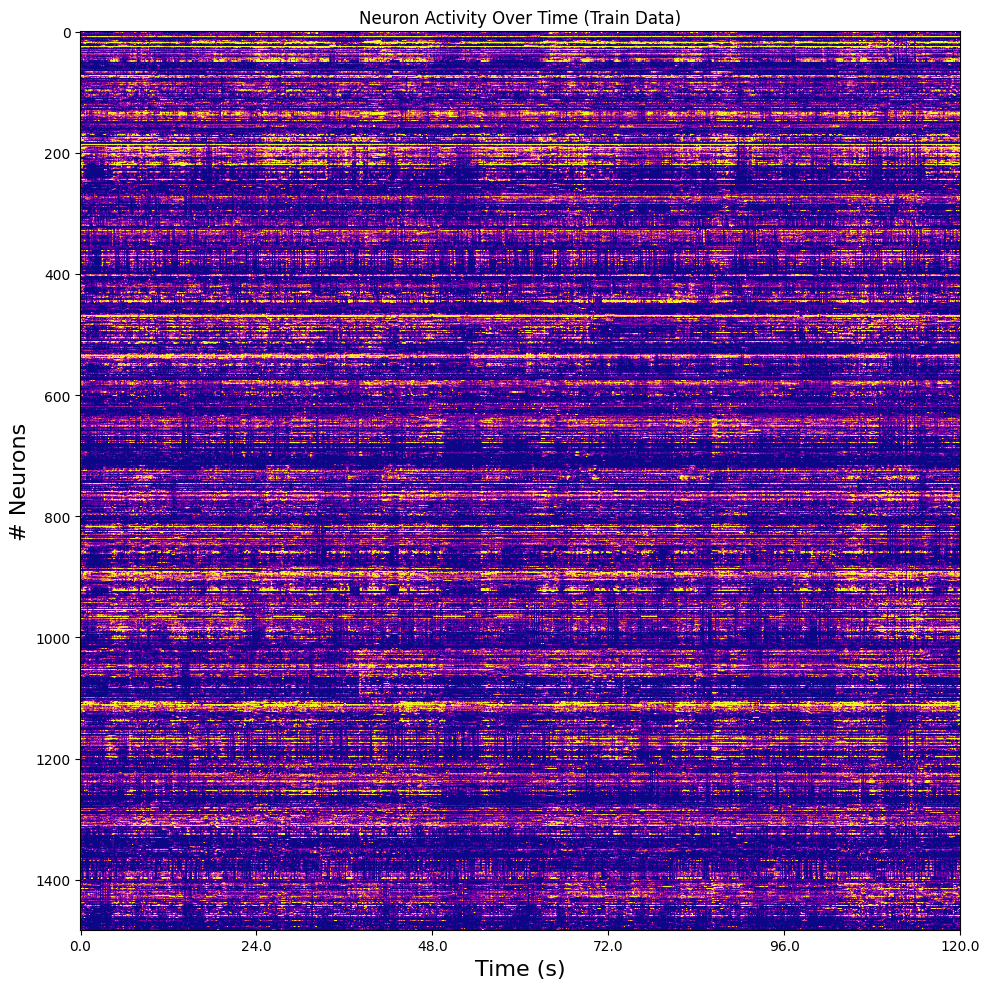

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

h5_file_path = "/content/drive/My Drive/EC523_Project/np_all.h5"
with h5py.File(h5_file_path, "r") as h5_file:
    np_train_data = torch.tensor(h5_file["train"][:], dtype=torch.float32)
    np_test_data = torch.tensor(h5_file["test"][:].squeeze(0), dtype=torch.float32)
    np_val_data = torch.tensor(h5_file["val"][:].squeeze(0), dtype=torch.float32)
    print(f"Train data shape: {np_train_data.shape}")  # (28800, 1500)
    print(f"Test data shape: {np_test_data.shape}")  # (3600, 1500)
    print(f"val data shape: {np_val_data.shape}")  # (3600, 1500)

plt.figure(figsize=(10, 10))
plt.imshow(np_train_data[:3600,:].T, aspect='auto', vmax=1, vmin=0, cmap = 'plasma')
plt.ylabel("# Neurons",fontsize = 16)
plt.xlabel("Time (s)", fontsize = 16)
plt.title("Neuron Activity Over Time (Train Data)")
plt.xticks(np.linspace(0, 3600, 6), np.round(np.linspace(0, 120, 6), 1))
plt.tight_layout()
plt.show()

## Visualize DINO features of the video frames


In [ ]:
import numpy as np

npy_file_path = "/content/drive/My Drive/EC523/Course Project/dino_features.npy"

behavior_features = torch.tensor(np.load(npy_file_path), dtype=torch.float32)

print(f"Data shape: {behavior_features.shape}")

dino_tsne = TSNE(n_components = 3)
dino_tsne_viz = dino_tsne.fit_transform(behavior_features[:900,:])

features = np.tile(behavior_features, [8, 1])

features_normalized = (features - features.mean(axis=0)) / features.std(axis=0)

def replace_with_row_average(matrix):
    assert matrix.shape[0] % 4 == 0, "Matrix rows must be divisible by 3."

    A = matrix.shape[0] // 4
    B = matrix.shape[1]

    reshaped = matrix.reshape(A, 4, B)

    group_means = reshaped.mean(axis=1, keepdims=True)

    result = np.tile(group_means, (1, 4, 1)).reshape(matrix.shape)

    return result

features_normalized = replace_with_row_average(features_normalized)

Data shape: torch.Size([3600, 768])


(-43.97966423034668, 34.9713939666748, -53.42103309631348, 38.07087440490723)

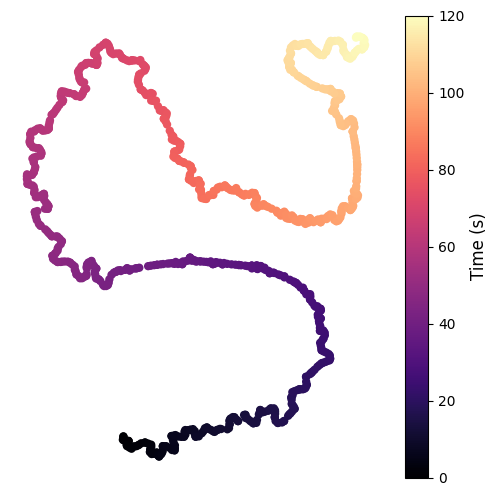

In [ ]:
dino_tsne = TSNE(n_components=2)
dino_tsne_viz = dino_tsne.fit_transform(behavior_features[:900, :])

time_values = np.linspace(0, 120, 900)

fig = plt.figure(figsize=(6, 6))
scatter = plt.scatter(dino_tsne_viz[:, 0], dino_tsne_viz[:, 1],
                      c=time_values, cmap='magma', edgecolor='none')

cbar = plt.colorbar(scatter, orientation="vertical")
cbar.set_label("Time (s)", fontsize=12)
cbar.set_ticks(np.linspace(0, 120, 7))
cbar.set_ticklabels([f"{int(t)}" for t in np.linspace(0, 120, 7)])

plt.axis('off')

## Train CEBRA models (Ca, Neuropixel, 1 frame window) using DINO features as behavior labels

- We train CEBRA-Behavior models using the DINO video frames features as behavior labels on Ca recording, ephys recording.


In [ ]:
np_train_data.shape
features_normalized.shape

(28800, 768)

In [ ]:

np_train = cebra.data.TensorDataset(neural=np_train_data,
                                    continuous=features_normalized)

In [ ]:
## Helper functions to define CEBRA solvers

def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    data_loader.to(kwargs['device'])
    model = cebra.models.init(kwargs['model_architecture'], data_loader.dataset.input_dimension,
                              kwargs['num_hidden_units'],
                              kwargs[
                                  'output_dimension'], norm).to(kwargs['device'])
    data_loader.dataset.configure_for(model)
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer,
                                            tqdm_on=kwargs['verbose'])

def multi_session_solver(data_loader, **kwargs):
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    for dataset in data_loader.dataset.iter_sessions():
        dataset.to(kwargs['device'])

    model = torch.nn.ModuleList([
        cebra.models.init(m, dataset.input_dimension,
                          kwargs['num_hidden_units'], kwargs['output_dimension'], norm)
        for dataset, m in zip(data_loader.dataset.iter_sessions(), kwargs['model_architecture'])
    ]).to(kwargs['device'])

    for m in model:
        m.to(kwargs['device'])
    for n, dataset in enumerate(data_loader.dataset.iter_sessions()):
        dataset.configure_for(model[n])
    if kwargs['distance'] == 'euclidean':
        criterion = cebra.models.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':
        criterion = cebra.models.InfoNCE(temperature=kwargs['temperature'])
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), criterion.parameters()), lr=kwargs['learning_rate'])
    return cebra.solver.MultiSessionSolver(model=model,
                                           criterion=criterion,
                                           optimizer=optimizer,
                                           tqdm_on=kwargs['verbose'])

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    dataset.configure_for(model)
    return model(dataset[torch.arange(len(dataset))].to(device)).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

def _compute_emissions_multi(solver, dataset):

    return {
        i :
            get_emissions(model, session)
            for i, (model, session) in enumerate(zip(solver.model, dataset.iter_sessions()))
    }

In [ ]:
train_steps = 10000
train_loader = cebra.data.ContinuousDataLoader(np_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset = 10)

cebra_np_train = single_session_solver(data_loader = train_loader, model_architecture = 'offset10-model-mse',
                 distance = 'cosine', num_hidden_units = 1024, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 5 * 1e-5)


In [ ]:
print(cebra.models.get_options())

['offset10-model', 'offset10-model-mse', 'offset5-model', 'offset1-model-mse', 'offset1-model', 'offset1-model-v2', 'offset1-model-v3', 'offset1-model-v4', 'offset1-model-v5', 'offset40-model-4x-subsample', 'resample-model', 'offset20-model-4x-subsample', 'resample5-model', 'offset4-model-2x-subsample', 'resample1-model', 'supervised10-model', 'supervised1-model', 'offset36-model', 'offset36-model-dropout', 'offset36-model-more-dropout']


In [ ]:
cebra_np_train.fit(train_loader)
cebra_np_emb = _compute_emissions_single(cebra_np_train, np_train)

pos: -0.9946 neg:  6.2518 total:  5.2573 temperature:  1.0000: 100%|██████████| 10000/10000 [03:30<00:00, 47.42it/s]


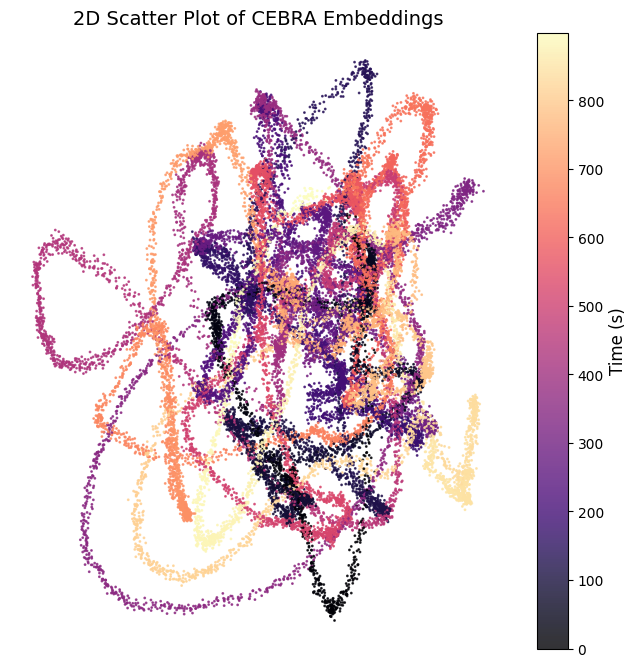

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(cebra_np_emb[:, 0], cebra_np_emb[:, 1],
                     c=np.tile(np.repeat(np.arange(900),4),8), cmap='magma', s=1, alpha=0.8)

cbar = plt.colorbar(scatter)
cbar.set_label("Time (s)", fontsize=12)

ax.set_title("2D Scatter Plot of CEBRA Embeddings", fontsize=14)

ax.axis('off')

plt.show()



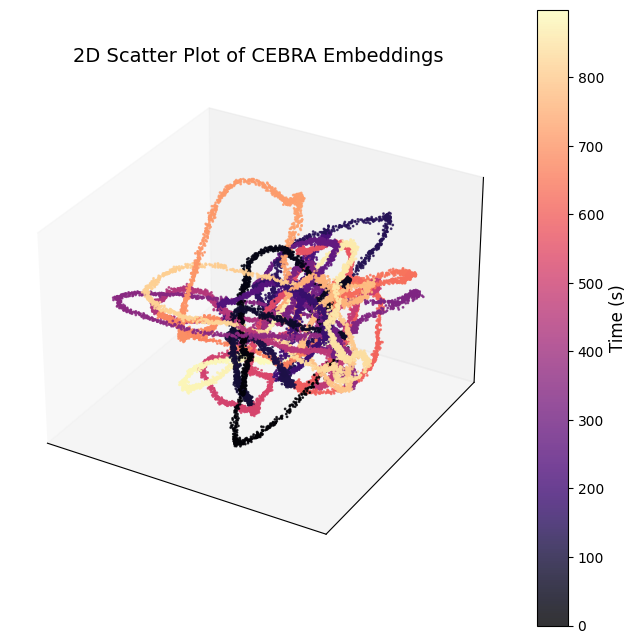

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(cebra_np_emb[:, 0], cebra_np_emb[:, 1], cebra_np_emb[:, 2],
                     c=np.tile(np.repeat(np.arange(900),4),8), cmap='magma', s=1, alpha=0.8)


cbar = plt.colorbar(scatter)
cbar.set_label("Time (s)", fontsize=12)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_title("2D Scatter Plot of CEBRA Embeddings", fontsize=14)

#ax.axis('off')

plt.show()



## Decoding movie frame IDs (1 frame window)

- We decode frame IDs (0-900, 30Hz, 30s movie) using CEBRA trained on Neuropixels only, jointly trained CEBRA and mean neural population activity of 1 frame window as a baseline.
- We use kNN decoder for CEBRA embeddings and kNN & naive Bayes model for baseline decoders.
- We use the 1-8th repeat as the train set, 9th repeat as the valid set, and the last 10th repeat as test set.


In [ ]:
def allen_frame_id_decode(train_fs, train_labels, test_fs, test_labels, modality = 'neuropixel', decoder = 'knn'):

    if modality == 'neuropixel':
        FACTOR = 4
    elif modality == 'ca':
        FACTOR = 1

    time_window = 1

    def feature_for_one_frame(feature):
        if isinstance(feature, torch.Tensor):
            feature = feature.cpu().numpy()
        return feature.reshape(-1,FACTOR,feature.shape[-1]).mean(axis = 1)

    train_fs = feature_for_one_frame(train_fs)
    test_fs = feature_for_one_frame(test_fs)


    if train_fs is None or test_fs is None:
        return [None], [None], None
    if decoder == 'knn':
        params = np.power(np.linspace(1, 10, 5, dtype=int), 2)
    elif decoder == 'bayes':
        params = np.logspace(-9, 3, 5)
    else:
        raise ValueError('Choose decoder between knn or bayes')
    errs = []

    for n in params:
        if decoder == 'knn':
            train_decoder = KNeighborsClassifier(n_neighbors=n,
                                                     metric='cosine')
        elif decoder == 'bayes':
            train_decoder = GaussianNB(var_smoothing = n)
        train_valid_idx = int(len(train_fs)/9*8)
        train_decoder.fit(train_fs[:train_valid_idx], train_labels[:train_valid_idx])
        pred = train_decoder.predict(train_fs[train_valid_idx:])
        err = train_labels[train_valid_idx:] - pred
        errs.append(abs(err).sum())

    if decoder == 'knn':
        test_decoder = KNeighborsClassifier(n_neighbors=params[np.argmin(errs)],
                                                     metric='cosine')
    elif decoder == 'bayes':
        test_decoder = GaussianNB(var_smoothing = params[np.argmin(errs)])

    test_decoder.fit(train_fs, train_labels)
    pred = test_decoder.predict(test_fs)
    frame_errors = pred - test_labels

    def _quantize_acc(frame_diff, time_window=1):

        true = (abs(frame_diff) < (time_window * 30)).sum()

        return true / len(frame_diff) * 100

    quantized_acc = _quantize_acc(frame_errors, time_window)

    return pred, frame_errors, quantized_acc


In [ ]:
np_loader_1frame = cebra.data.ContinuousDataLoader(np_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset = 1)

cebra_np_1frame = single_session_solver(data_loader = train_loader, model_architecture = 'offset1-model-v5',
                 distance = 'cosine', num_hidden_units = 256, output_dimension = 128,
                verbose = True, device = DEVICE, temperature = 1, learning_rate = 3e-4)



In [ ]:
pred_knn, errs_knn, acc_knn =allen_frame_id_decode(np_train_data, np.tile(np.arange(900), 8),
                     np_test_data, np.arange(900), modality = 'neuropixel', decoder = 'knn')

pred_bayes, errs_bayes, acc_bayes=allen_frame_id_decode(np_train_data, np.tile(np.arange(900), 8),
                     np_test_data, np.arange(900), modality = 'neuropixel', decoder = 'bayes')



In [ ]:
np_test = cebra.data.TensorDataset(neural=np_test_data,
                                    continuous=features_normalized)
cebra_np_emb = _compute_emissions_single(cebra_np_train, np_train)
cebra_np_test = _compute_emissions_single(cebra_np_train, np_test)
pred_cebra, errs_cebra ,acc_cebra = allen_frame_id_decode(cebra_np_emb, np.tile(np.arange(900), 8), cebra_np_test, np.arange(900), modality = 'neuropixel', decoder = 'knn')

In [ ]:
print(f'kNN baseline: {acc_knn:.2f}%')
print(f'CEBRA Neuropixel: {acc_cebra:.2f}%')

kNN baseline: 76.67%
CEBRA Neuropixel: 98.33%


In [ ]:
np.save('/content/drive/My Drive/EC523_Project/pred_frames_test.npy', pred_cebra)